# Imports

In [33]:
# User-defined functions!
# All data preparation functions for GDP data and explanatory variables
from Functions.data_prep import data_GDP
# imports for Moran's I analysis and plotting graphs
from Functions.spatial_functions import spatial_weight_matrix, neighborhood_dict_creation, global_moran_val, local_moran_val,lisa_df_update, local_moran_density_plot, local_moran_plots, lisa_cluster_map

# All required imports
import pandas as pd
import matplotlib.pyplot as plt
import random

random.seed(120)

# Spatial Autocorrelation Analysis

## Data preparation & Spatial Weights Creation

In [34]:
# Data preparation and cleaning for GDP data
# Setting time_period option to average over all years since this is spatial analysis and time is aggregated
time_period_option = 'average_all_years'
gdf_lvl = data_GDP(3, time_period_option)
# Setting index to NUTS_ID before you create the spatial weights (so neighborhood dictionary has NUTS ID values)
gdf_lvl.set_index('NUTS_ID', inplace=True)
w_adaptive = spatial_weight_matrix(gdf_lvl, 15)
neighbor_weights_dict = neighborhood_dict_creation(w_adaptive)

### Global and Local Moran's I

In [35]:
global_moran = global_moran_val(gdf_lvl, 'GDP_VALUE', w_adaptive)
lisa = local_moran_val(gdf_lvl, 'GDP_VALUE', w_adaptive)

In [36]:
print("Global Moran's I value: "+str(global_moran.I))
print("p-value: "+str(global_moran.p_sim))

Global Moran's I value: 0.5594428103725201
p-value: 0.001


#### Neighbour number v.s. Global Moran's I

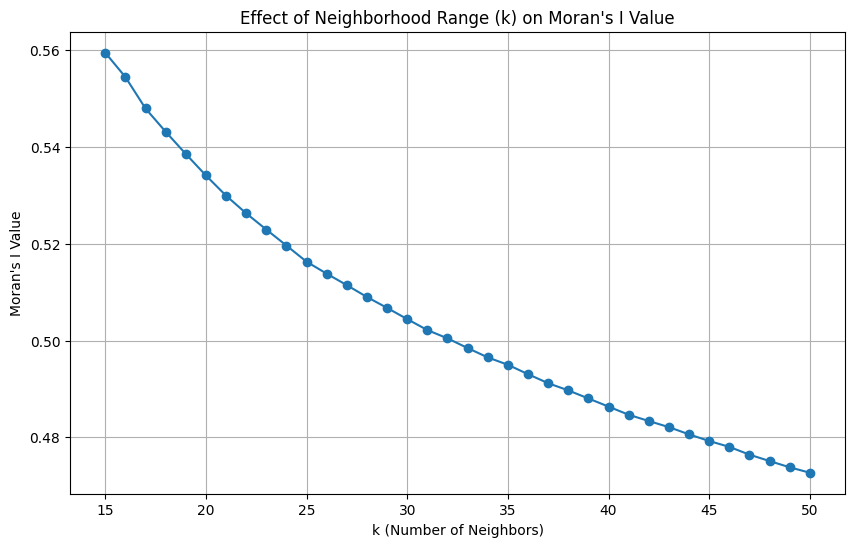

In [37]:
# Define the range of k values you want to test
k_values = range(15, 51)  # testing k from 1 to 50
# Initialize an empty list to store Moran's I value
moran_values = []

# Loop through each k value
for k in k_values:
    # Create the spatial weight matrix for the current k value
    w_adaptive = spatial_weight_matrix(gdf_lvl, k)
    # Calculate Moran's I value
    moran = global_moran_val(gdf_lvl, 'GDP_VALUE', w_adaptive)
    # Append the Moran's I value to the list
    moran_values.append(moran.I)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, moran_values, marker='o')
plt.title("Effect of Neighborhood Range (k) on Moran's I Value")
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Moran's I Value")
plt.grid(True)
plt.show()

In [38]:
# Remember to reset index before updating it with lisa values and corresponding significance and quadrant values
gdf_lvl.reset_index(inplace=True)

In [39]:
# Updating the dataframe to include local lisa information
gdf_lvl = lisa_df_update(gdf_lvl, lisa)

### Local Moran's I plots

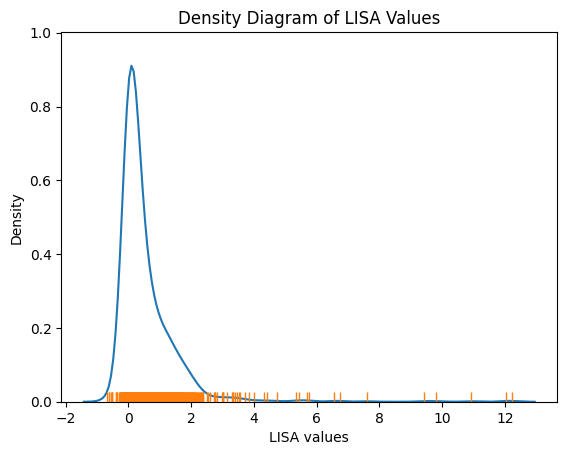

In [40]:
local_moran_density_plot(lisa)

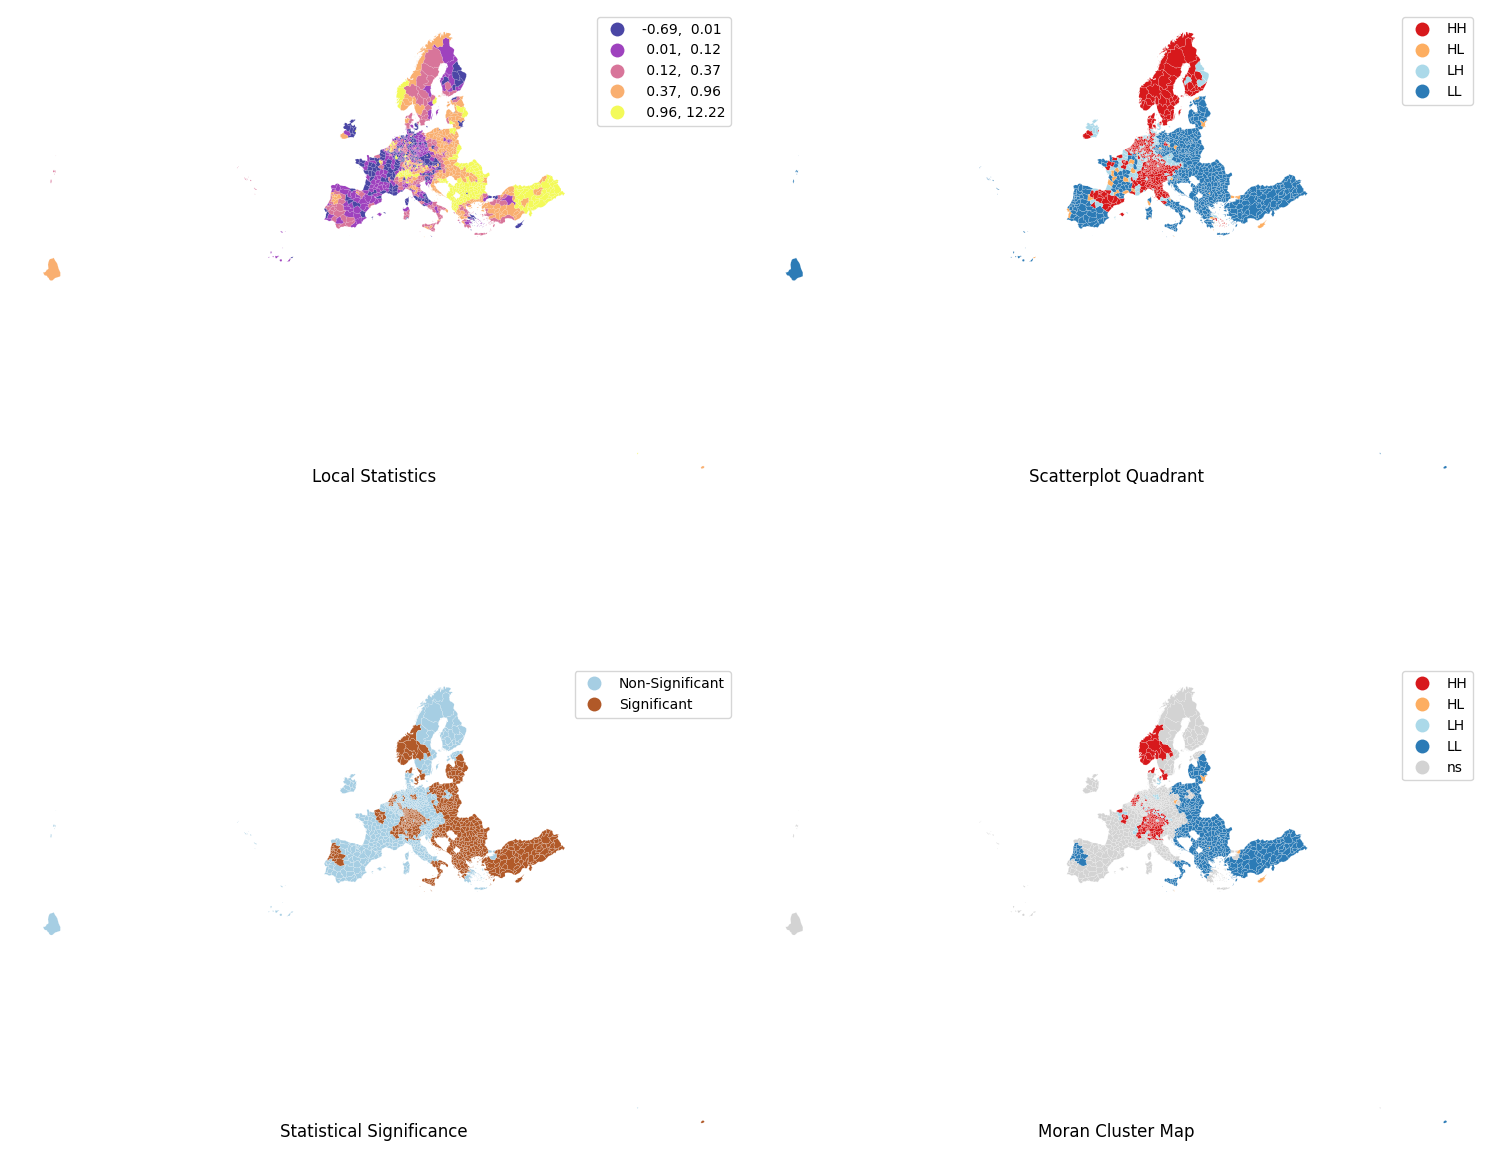

In [41]:
local_moran_plots(gdf_lvl, lisa)

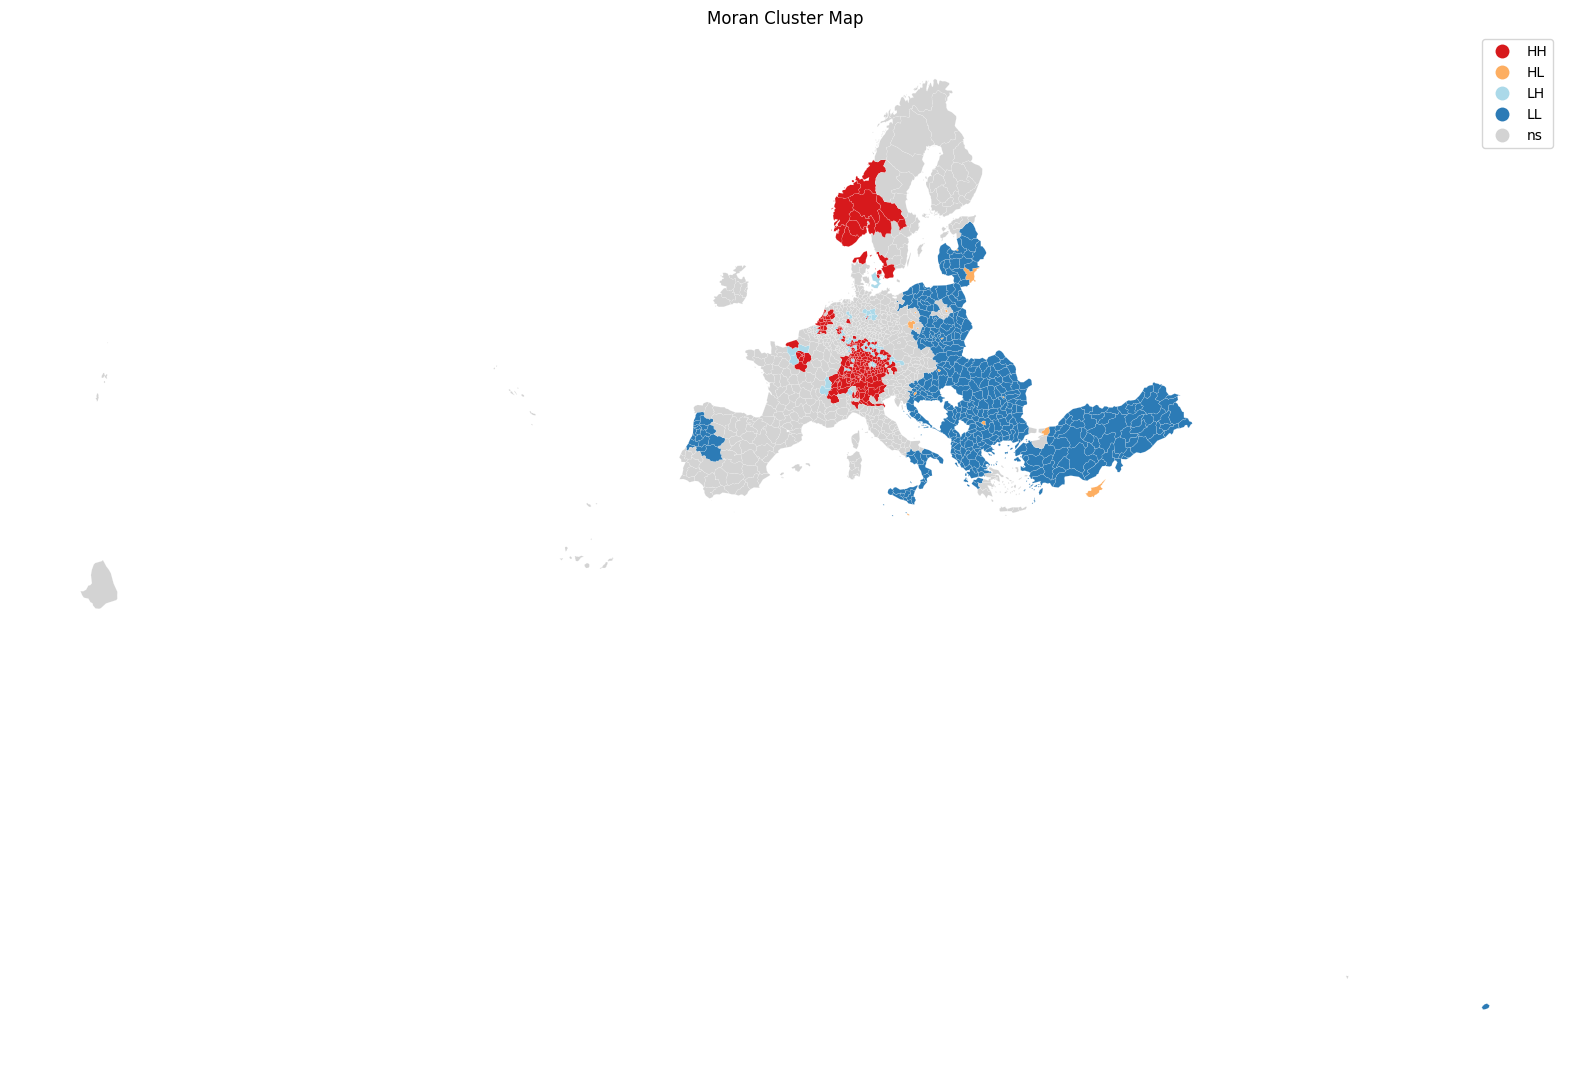

In [42]:
lisa_cluster_map(lisa, gdf_lvl)

# NUTS 2 v.s. NUTS 3 level

In [43]:
# Reading NUTS 2 level dataframe
gdf_lvl_2 = pd.read_csv("results/SAC_local_NUTS2.csv")
gdf_lvl_2 = gdf_lvl_2.drop(columns=['Unnamed: 0'])
original_len = len(gdf_lvl_2)
gdf_lvl_2 = gdf_lvl_2[gdf_lvl_2['LISA_sig']=='Significant']
final_len = len(gdf_lvl_2)
print("Percentage of regions lost at NUTS 2 level after Significance test:")
proportion = (original_len-final_len)/original_len
print(proportion*100)

Percentage of regions lost at NUTS 2 level after Significance test:
35.51724137931034


In [44]:
# Renaming NUTS 3 level dataframe
gdf_lvl_3 = gdf_lvl.copy()
original_len = len(gdf_lvl_3)
gdf_lvl_3 = gdf_lvl_3[gdf_lvl_3['LISA_sig']=='Significant']
final_len = len(gdf_lvl_3)
print("Percentage of regions lost at NUTS 3 level after Significance test:")
proportion = (original_len-final_len)/original_len
print(proportion*100)

Percentage of regions lost at NUTS 3 level after Significance test:
48.48714069591528


## Proportion of HL,HH,LL, and LH values

In [45]:
# Calculating proportion of each quadrant in both dataframes
# Calculate the proportion of each value
value_counts_nuts2 = gdf_lvl_2['LISA_quadrant'].value_counts(normalize=True)
# Convert to dictionary
proportions_nuts2 = {str(key): value for key, value in value_counts_nuts2.items()}
print("NUTS 2 level results:")
proportions_nuts2

NUTS 2 level results:


{'3': 0.45454545454545453,
 '1': 0.44385026737967914,
 '2': 0.058823529411764705,
 '4': 0.0427807486631016}

In [46]:
# Calculate the proportion of each value
value_counts_nuts3 = gdf_lvl_3['LISA_quadrant'].value_counts(normalize=True)
# Convert to dictionary
proportions_nuts3 = {str(key): value for key, value in value_counts_nuts3.items()}
print("NUTS 3 level results:")
proportions_nuts3

NUTS 3 level results:


{'3': 0.5462555066079295,
 '1': 0.3568281938325991,
 '2': 0.0763582966226138,
 '4': 0.020558002936857563}

## Spatial outlier similarity

In [47]:
# Extracting HL regions
gdf_lvl2_HL = gdf_lvl_2[gdf_lvl_2['LISA_quadrant']==4]
gdf_lvl3_HL = gdf_lvl_3[gdf_lvl_3['LISA_quadrant']==4]

AT NUTS 2 level, every country identified has only one region within: CY, EL, HR, HU, LT, PL, RO, TR
At NUTS 3 level, minimum country code is BG, CY, HR , HU , LT , LV and MT with only one region identified each. maximum country code is PL (5 regions identified)
So an interesting observation is that at the NUTS 3 level, 5 sub-regions in PL (Poland) are identified as significant compared to only one sub-region at the NUTS 2 level.

In [48]:
# Extracting LH regions
gdf_lvl2_LH = gdf_lvl_2[gdf_lvl_2['LISA_quadrant'] == 2]
gdf_lvl3_LH = gdf_lvl_3[gdf_lvl_3['LISA_quadrant'] == 2]

For significant Low-High regions, an interesting observation is that at the NUTS 2 level, only one region within Denmark (country code: DE) was identified however, at the NUTS 3 level, 15 sub-regions are identified.
At the NUTS 2 level, Belgium has the highest number of LH regions at 5.